In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

print("NumPy version:", np.__version__)


NumPy version: 2.4.1


In [3]:
# main reference used: https://www.youtube.com/watch?v=w8yWXqWQYmU

In [20]:
def load_mnist_images(path):
    with open(path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    return data.reshape(-1, 28*28)

def load_mnist_labels(path):
    with open(path, 'rb') as f:
        return np.frombuffer(f.read(), dtype=np.uint8, offset=8)

# Load data
X_train = load_mnist_images("./data/mnist/train-images.idx3-ubyte")
y_train = load_mnist_labels("./data/mnist/train-labels.idx1-ubyte")

X_test = load_mnist_images("./data/mnist/t10k-images.idx3-ubyte")
y_test = load_mnist_labels("./data/mnist/t10k-labels.idx1-ubyte")

# Ensure correct shapes before stacking
X_train = X_train.reshape(X_train.shape[0], 784)
X_test  = X_test.reshape(X_test.shape[0], 784)

y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

# Normalize
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0


train_data = np.hstack([y_train, X_train])
test_data  = np.hstack([y_test,  X_test])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(60000, 784) (60000, 1)
(10000, 784) (10000, 1)


Train Data (numpy array check)): (69000, 785)
Test Data (numpy array check)): (1000, 785)
Label check: 4.0


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

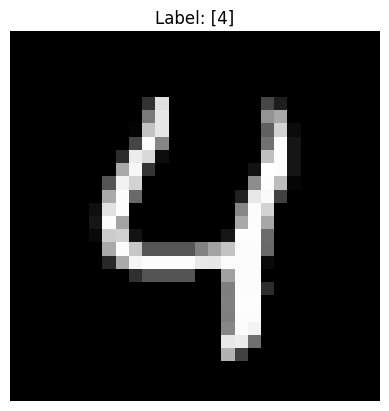

In [21]:
# Combine labels + pixels like the CSV format
train_data = np.hstack([
    y_train.reshape(-1, 1),   # first column = label
    X_train                   # remaining 784 columns = pixels
])

test_data = np.hstack([
    y_test.reshape(-1, 1),   # first column = label
    X_test                  # remaining 784 columns = pixels
])

df1 = pd.DataFrame(train_data)
df2 = pd.DataFrame(test_data)

data_train = df1.to_numpy()
data_dev = df2.to_numpy()

data_dev_keep = data_dev[:1000]
data_dev_move = data_dev[1000:]

data_train = np.vstack([data_train, data_dev_move])
data_dev = data_dev_keep

print("Train Data (numpy array check)):",data_train.shape)
print("Test Data (numpy array check)):",data_dev.shape)

idx = 4

print("Label check:", data_dev[idx,0])

plt.imshow(X_test[idx].reshape(28, 28), cmap="grey")
plt.title(f"Label: {y_test[idx]}")
plt.axis("off")

In [22]:
m, n = data_dev.shape[0] + data_train.shape[0] ,data_dev.shape[1] 
print(m,n)

70000 785


In [23]:
np.random.shuffle(data_dev)
data_dev = data_dev.T
X_dev = data_dev[1:n]
Y_dev = data_dev[0]

np.random.shuffle(data_train)
data_train = data_train.T
X_train = data_train[1:n]
Y_train = data_train[0]

Y_train = Y_train.astype(int)
Y_dev   = Y_dev.astype(int)

print("Test dims, imgs and labels:", X_dev.shape, Y_dev.shape)
print("Train dims:", X_train.shape, Y_train.shape)


Test dims, imgs and labels: (784, 1000) (1000,)
Train dims: (784, 69000) (69000,)


In [24]:
X_train[:,0].shape

(784,)

In [51]:
def init_params():
    W1 = np.random.rand(32, 784) - 0.5
    b1 = np.random.rand(32, 1) - 0.5
    W2 = np.random.rand(10, 32) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, m):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [52]:
def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


In [53]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def gradient_descent(X, Y, alpha, iterations):
    m = X.shape[1]
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, m)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [54]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
0.159
Iteration:  10
0.3148695652173913
Iteration:  20
0.42281159420289854
Iteration:  30
0.5004637681159421
Iteration:  40
0.5579130434782609
Iteration:  50
0.6029565217391304
Iteration:  60
0.6401739130434783
Iteration:  70
0.6679275362318841
Iteration:  80
0.6906666666666667
Iteration:  90
0.7106376811594203
Iteration:  100
0.7271449275362318
Iteration:  110
0.741
Iteration:  120
0.7534927536231885
Iteration:  130
0.7645072463768116
Iteration:  140
0.7741884057971015
Iteration:  150
0.7833043478260869
Iteration:  160
0.7904927536231884
Iteration:  170
0.7962753623188406
Iteration:  180
0.8015797101449276
Iteration:  190
0.8068405797101449
Iteration:  200
0.8114347826086956
Iteration:  210
0.8157246376811594
Iteration:  220
0.8200144927536231
Iteration:  230
0.8241739130434783
Iteration:  240
0.8279855072463768
Iteration:  250
0.8311304347826087
Iteration:  260
0.8341449275362319
Iteration:  270
0.8370144927536232
Iteration:  280
0.8397971014492753
Iteration:  290
0.842

In [55]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


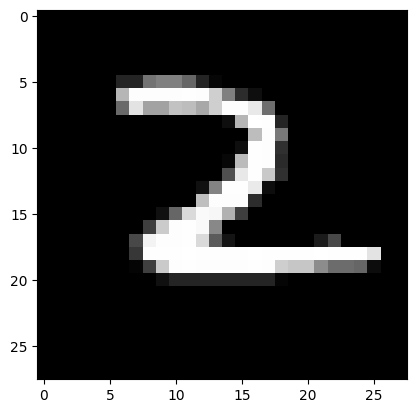

Prediction:  [5]
Label:  5


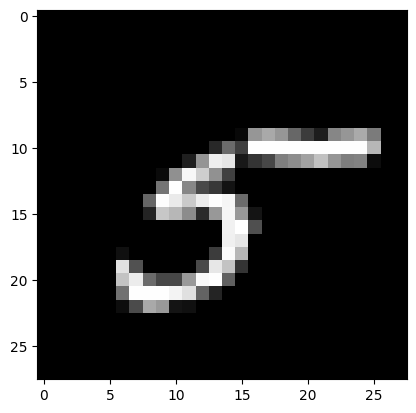

In [58]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)

In [62]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
printf("Test dataset accuracy: %.2f%",get_accuracy(dev_predictions, Y_dev)*100)

SyntaxError: invalid decimal literal (2796408735.py, line 2)